# Essential Water Quality Analysis & Prediction

Team members:


1.   Donifa Babu B M
2.   Eshwaran ABR
3.   Sadurthika M
4.   Vishnuram VR

# Upload dataset

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore
import ibm_boto3
from botocore.client import Config
import json
import pandas as pd


In [79]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='GJZkSFeEetlaOYAYImkHFzQ5rdjzZ1h4J0tEwMjQrsCe',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'waterqualityanalyser-donotdelete-pr-rnbq3gmycblrnz'
object_key = 'WaterAnalysis.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,DO,PH,CO,BOD,NI,Tot_col,year,wqi
0,6.7,7.5,203.0,6.857892,0.1,27.0,2014,84
1,5.7,7.2,189.0,2.000000,0.2,8391.0,2014,76
2,6.3,6.9,179.0,1.700000,0.1,5330.0,2014,79
3,5.8,6.9,64.0,3.800000,0.5,8443.0,2014,69
4,5.8,7.3,83.0,1.900000,0.4,5500.0,2014,77


In [80]:
# Selecting 1900 samples, because samples having indices greater than 1900 are not correct
df.shape

(1900, 8)

In [81]:
df.head()

,DO,PH,CO,BOD,NI,Tot_col,year,wqi
0,6.7,7.5,203.0,6.857892,0.1,27.0,2014,84
1,5.7,7.2,189.0,2.000000,0.2,8391.0,2014,76
2,6.3,6.9,179.0,1.700000,0.1,5330.0,2014,79
3,5.8,6.9,64.0,3.800000,0.5,8443.0,2014,69
4,5.8,7.3,83.0,1.900000,0.4,5500.0,2014,77


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DO       1900 non-null   float64
 1   PH       1900 non-null   float64
 2   CO       1900 non-null   float64
 3   BOD      1900 non-null   float64
 4   NI       1900 non-null   float64
 5   Tot_col  1900 non-null   float64
 6   year     1900 non-null   int64  
 7   wqi      1900 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 118.9 KB


In [83]:
df.shape

(1900, 8)

In [84]:
df.describe()

,DO,PH,CO,BOD,NI,Tot_col,year,wqi
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1.900000e+03,1900.000000,1900.000000
mean,6.354635,7.227912,1871.808225,6.857892,1.658681,5.604394e+05,2010.373158,75.668421
std,1.333341,0.649011,5634.005557,27.381555,3.938236,1.407929e+07,2.708444,13.614591
min,0.000000,0.000000,11.000000,0.100000,0.000000,0.000000e+00,2005.000000,19.000000
25%,5.900000,6.900000,88.000000,1.200000,0.270000,1.147500e+02,2008.000000,70.000000
50%,6.600000,7.300000,202.000000,1.900000,0.620000,5.410000e+02,2011.000000,79.000000
75%,7.100000,7.600000,668.000000,3.900000,1.658681,2.983500e+03,2013.000000,84.000000
max,11.400000,9.010000,65700.000000,534.500000,108.700000,5.110909e+08,2014.000000,99.000000


# Handling missing values

In [85]:
# Converting object data type to numeric
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

DO         float64
PH         float64
CO         float64
BOD        float64
NI         float64
Tot_col    float64
year         int64
wqi          int64
dtype: object

In [86]:
df.isnull().sum()

DO         0
PH         0
CO         0
BOD        0
NI         0
Tot_col    0
year       0
wqi        0
dtype: int64

In [87]:
#Let us rename the columns for simplification
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "CO", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})


In [88]:
df['DO'].fillna(df['DO'].mean(), inplace=True)
df['PH'].fillna(df['PH'].mean(), inplace=True)
df['CO'].fillna(df['CO'].mean(), inplace=True)
df['BOD'].fillna(df['BOD'].mean(), inplace=True)
df['NI'].fillna(df[ 'NI'].mean(), inplace=True)
df['Tot_col'].fillna(df[ 'Tot_col'].mean(), inplace=True)

In [89]:
df.columns

Index(['DO', 'PH', 'CO', 'BOD', 'NI', 'Tot_col', 'year', 'wqi'], dtype='object')

# Water Quality Index Calculation

In [90]:
#calulation of Ph

df[ 'npH' ]=df.PH. apply(lambda x: (100 if (8.5>=x>=7)
                                else(80 if (8.6>= x >=8.5) or (6.9>=x>=6.8)
                                    else(60 if (8.8>=x>=8.6) or (6.8>=x>=6.7)
                                        else(40 if (9>=x>=8.8) or (6.7>=x>=6.5)
                                            else 0)))))

In [91]:
#calculation of dissolved oxygen
df[ 'ndo' ]=df. DO. apply(lambda x: (100 if (x>=6)

else(80 if (6>=x>=5.1)
else(60 if (5>=x>=4.1)
else(40 if (4>=x>=3)
else 0) )) ) )

In [92]:
#calculation of total coliform
df[ 'nco' ]=df.Tot_col . apply(lambda x: (100 if (5>=x>=0)
else(80 if (50>=x>=5)

else(60 if (500>=x>=50)
else(40 if (10000>=x>=500)
else 0) ))) )



In [93]:
#calc of B.D.O

df[ 'nbdo' ]=df.BOD. apply(lambda x: (100 if (3>=x>=0)
else(80 if (6>=x>=3)

else(60 if (80>=x>=6)
else(40 if (125>=x>=80)
else 0)))) )

In [94]:
#calculation of electrical conductivity
df[ 'nec' ]=df.CO. apply (lambda x: (100 if (75>=x>=0)
else(80 if (150>=x>=75)

else(60 if (225>=x>=150)
else(40 if (300>=x>=225)
else 0))) ) )


In [95]:
#Calulation of nitrate
df[ 'nna' ]=df. NI. apply( lambda x: (100 if (20>=x>=0)
else(80 if (50>=x>=20)

else(60 if (100>=x>=50)
else(40 if (200>=x>=100)
else 0) ) ) ) )

In [96]:
# Calculate water quality index WQI
df[ 'wph' ]=df.npH * 0.165
df[ 'wdo' ]=df. ndo * 0.281

df[ 'wbdo' ]=df. nbdo * 0.234
df[ 'wec' ]=df.nec* 0.009
df[ 'wna' ]=df.nna * 0.028

df[ 'wco' ]=df.nco * 0.281
df[ 'wqi' ]=df.wph+df.wdo+df.wbdo+df.wec+df.wna+df.wco
df

,DO,PH,CO,BOD,NI,Tot_col,year,wqi,npH,ndo,nco,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco
0,6.7,7.50,203.0,6.857892,0.100000,27.0,2014,84.46,100,100,80,60,60,100,16.5,28.10,14.04,0.54,2.8,22.48
1,5.7,7.20,189.0,2.000000,0.200000,8391.0,2014,76.96,100,80,40,100,60,100,16.5,22.48,23.40,0.54,2.8,11.24
2,6.3,6.90,179.0,1.700000,0.100000,5330.0,2014,79.28,80,100,40,100,60,100,13.2,28.10,23.40,0.54,2.8,11.24
3,5.8,6.90,64.0,3.800000,0.500000,8443.0,2014,69.34,80,80,40,80,100,100,13.2,22.48,18.72,0.90,2.8,11.24
4,5.8,7.30,83.0,1.900000,0.400000,5500.0,2014,77.14,100,80,40,100,80,100,16.5,22.48,23.40,0.72,2.8,11.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,7.4,7.00,88.5,0.977000,0.186000,105.0,2005,88.38,100,100,60,100,80,100,16.5,28.10,23.40,0.72,2.8,16.86
1896,6.6,7.81,603.2,2.675000,0.263000,191.0,2005,87.66,100,100,60,100,0,100,16.5,28.10,23.40,0.00,2.8,16.86
1897,6.6,7.49,571.5,2.091000,0.256000,273.0,2005,87.66,100,100,60,100,0,100,16.5,28.10,23.40,0.00,2.8,16.86
1898,5.4,7.16,75.8,2.092000,1.658681,513.0,2005,77.14,100,80,40,100,80,100,16.5,22.48,23.40,0.72,2.8,11.24


In [97]:
#calculation overall wai for each year
average=df. groupby( 'year' ) [ 'wqi' ]. mean()
average . head()

year
2005    74.013729
2006    72.909714
2007    74.233000
2008    73.506289
2009    74.456685
Name: wqi, dtype: float64

# Visualization of Dataset

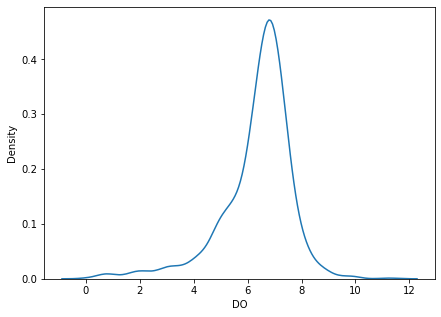

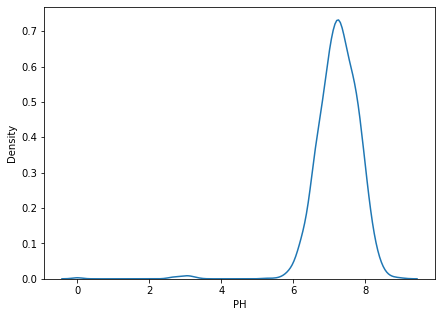

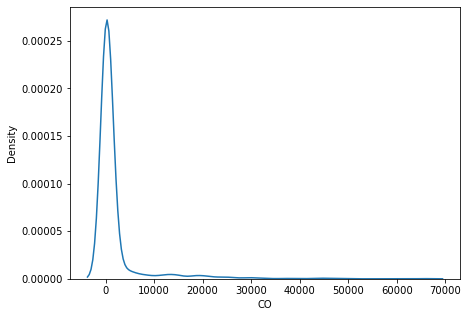

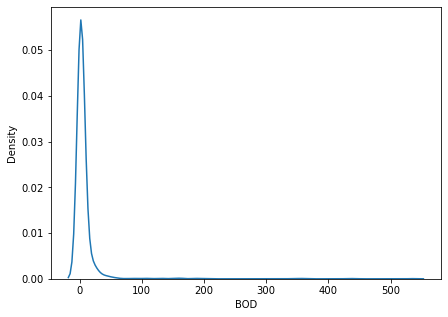

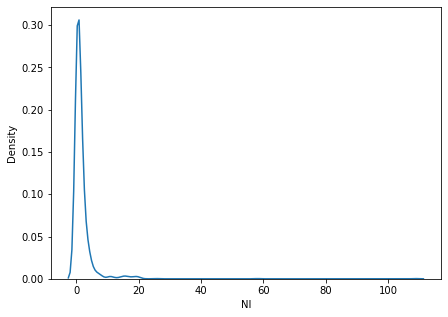

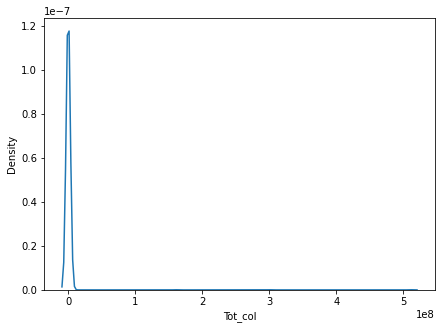

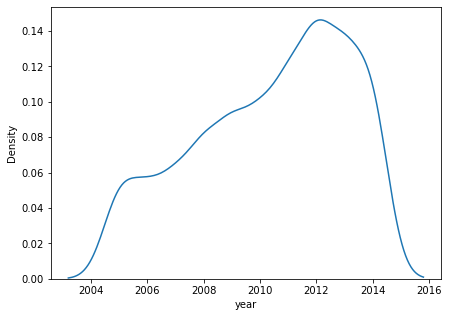

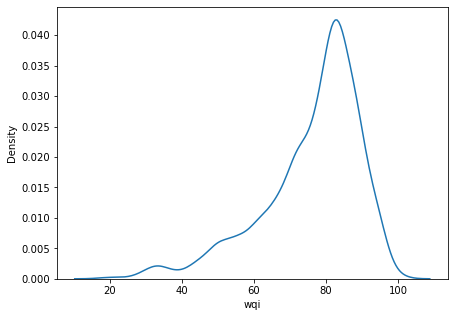

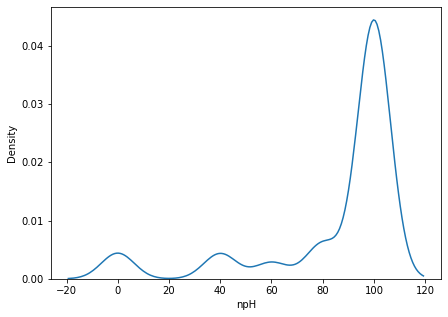

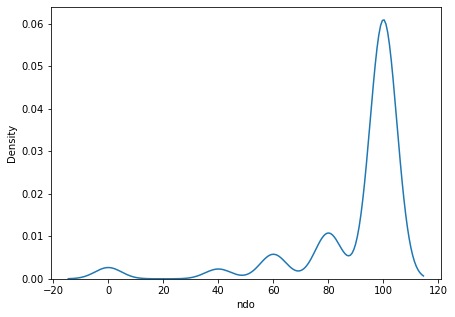

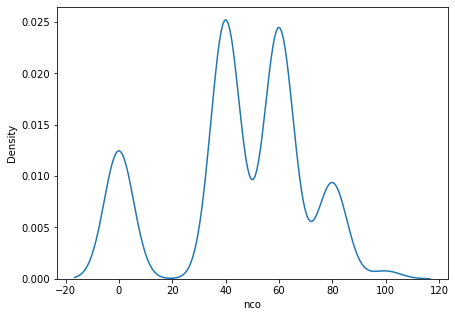

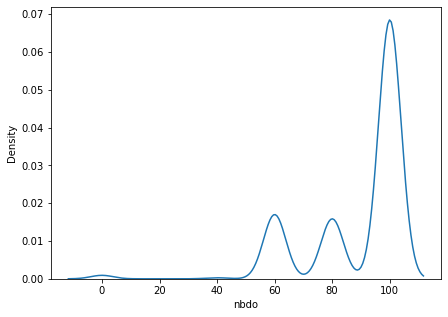

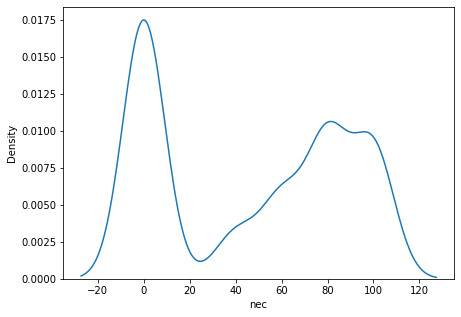

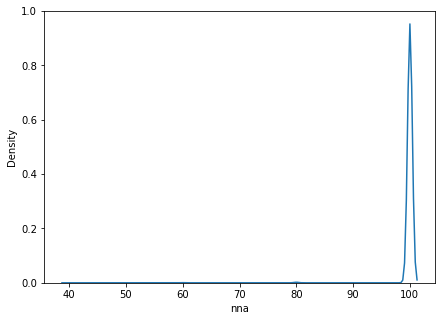

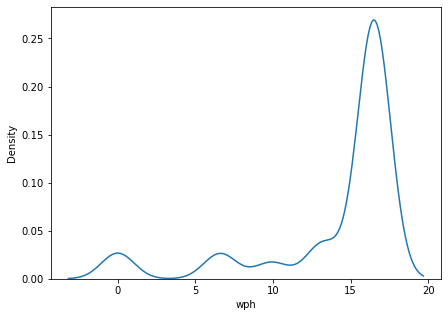

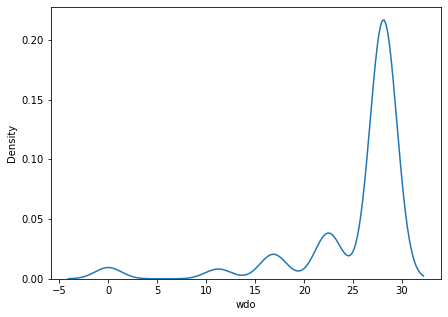

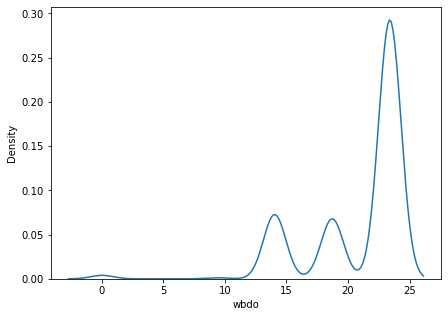

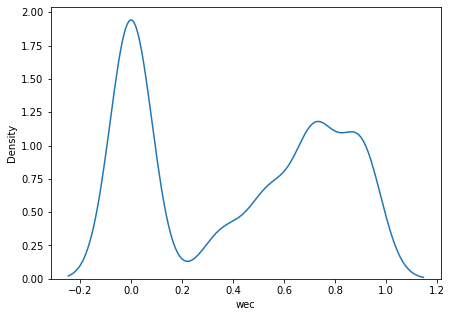

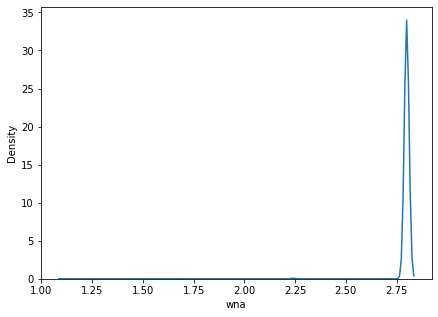

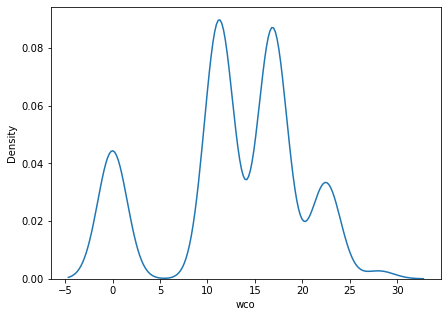

In [98]:
# PLotting PDFs of all the numeric attributes in the dataset

df = df.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df)

# Classification based on WQI

In [99]:
df.shape

(1900, 20)

In [100]:
df['wqi']

0       84.46
1       76.96
2       79.28
3       69.34
4       77.14
        ...  
1895    88.38
1896    87.66
1897    87.66
1898    77.14
1899    77.14
Name: wqi, Length: 1900, dtype: float64

In [101]:
df.columns

Index(['DO', 'PH', 'CO', 'BOD', 'NI', 'Tot_col', 'year', 'wqi', 'npH', 'ndo',
       'nco', 'nbdo', 'nec', 'nna', 'wph', 'wdo', 'wbdo', 'wec', 'wna', 'wco'],
      dtype='object')

In [102]:
df.tail()

,DO,PH,CO,BOD,NI,Tot_col,year,wqi,npH,ndo,nco,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco
1895,7.4,7.00,88.5,0.977,0.186000,105.0,2005,88.38,100,100,60,100,80,100,16.5,28.10,23.4,0.72,2.8,16.86
1896,6.6,7.81,603.2,2.675,0.263000,191.0,2005,87.66,100,100,60,100,0,100,16.5,28.10,23.4,0.00,2.8,16.86
1897,6.6,7.49,571.5,2.091,0.256000,273.0,2005,87.66,100,100,60,100,0,100,16.5,28.10,23.4,0.00,2.8,16.86
1898,5.4,7.16,75.8,2.092,1.658681,513.0,2005,77.14,100,80,40,100,80,100,16.5,22.48,23.4,0.72,2.8,11.24
1899,5.4,7.37,104.8,1.802,0.215000,557.0,2005,77.14,100,80,40,100,80,100,16.5,22.48,23.4,0.72,2.8,11.24


In [103]:
df.describe()

,DO,PH,CO,BOD,NI,Tot_col,year,wqi,npH,ndo,nco,nbdo,nec,nna,wph,wdo,wbdo,wec,wna,wco
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1.900000e+03,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,6.354635,7.227912,1871.808225,6.857892,1.658681,5.604394e+05,2010.373158,76.151642,84.926316,89.705263,45.673684,89.221053,46.915789,99.905263,14.012842,25.207179,20.877726,0.422242,2.797347,12.834305
std,1.333341,0.649011,5634.005557,27.381555,3.938236,1.407929e+07,2.708444,13.607085,29.109024,21.907880,24.995394,17.609167,41.203118,1.889934,4.802989,6.156114,4.120545,0.370828,0.052918,7.023706
min,0.000000,0.000000,11.000000,0.100000,0.000000,0.000000e+00,2005.000000,19.300000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,1.120000,0.000000
25%,5.900000,6.900000,88.000000,1.200000,0.270000,1.147500e+02,2008.000000,70.800000,80.000000,80.000000,40.000000,80.000000,0.000000,100.000000,13.200000,22.480000,18.720000,0.000000,2.800000,11.240000
50%,6.600000,7.300000,202.000000,1.900000,0.620000,5.410000e+02,2011.000000,79.640000,100.000000,100.000000,40.000000,100.000000,60.000000,100.000000,16.500000,28.100000,23.400000,0.540000,2.800000,11.240000
75%,7.100000,7.600000,668.000000,3.900000,1.658681,2.983500e+03,2013.000000,84.360000,100.000000,100.000000,60.000000,100.000000,80.000000,100.000000,16.500000,28.100000,23.400000,0.720000,2.800000,16.860000
max,11.400000,9.010000,65700.000000,534.500000,108.700000,5.110909e+08,2014.000000,99.800000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,16.500000,28.100000,23.400000,0.900000,2.800000,28.100000


In [104]:
df.dtypes

DO         float64
PH         float64
CO         float64
BOD        float64
NI         float64
Tot_col    float64
year         int64
wqi        float64
npH          int64
ndo          int64
nco          int64
nbdo         int64
nec          int64
nna          int64
wph        float64
wdo        float64
wbdo       float64
wec        float64
wna        float64
wco        float64
dtype: object

# Prediction - 5 Algorithms
#  & Model Evaluation 

In [105]:
pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=a0841eb9a29a59dd620c2652d84ca33bb1947002d48075f87e7fe7f213663522
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [106]:
#Splitting the data into dependent and independent variables
X= df[['year', 'DO', 'PH', 'CO','BOD','NI','Tot_col']]  
df['wqi']=df['wqi'].astype('int')
Y= df[['wqi']]

In [107]:
X.shape

(1900, 7)

In [108]:
Y.shape

(1900, 1)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import metrics 
import math
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split( X, Y,test_size=0.2, random_state=10)

#from sklearn.preprocessing import StandardScaler
#sc_X = StandardScaler()
#X_train = sc_X.fit_transform(X_train)
#X_test = sc_X.transform(X_test)

#{Decision Tree Model}
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,Y_train)
clf_pred=clf.predict(X_test)
clf_accuracy=metrics.accuracy_score(Y_test,clf_pred)
print("1) Using Decision Tree Prediction, Accuracy is " + str(clf_accuracy))

#{K Neighbors Classifier}
knn = KNeighborsClassifier(n_neighbors=7)
knn=knn.fit(X_train,Y_train.values.ravel())
knn_pred=knn.predict(X_test)
knn_accuracy=metrics.accuracy_score(Y_test,knn_pred)
print ("2) Using K Neighbors Classifier Prediction, Accuracy is " + str(knn_accuracy))

#{using MLPClassifier}
mlpc = MLPClassifier()
mlpc.fit(X_train,Y_train.values.ravel())
mlpc_pred=mlpc.predict(X_test)
mlpc_accuracy=metrics.accuracy_score(Y_test,mlpc_pred)
print ("3) Using MLPC Classifier Prediction, Accuracy is " + str(mlpc_accuracy))

#{using MLPClassifier}
rfor = RandomForestClassifier()
rfor.fit(X_train,Y_train.values.ravel())
rfor_pred=rfor.predict(X_test)
rfor_accuracy=metrics.accuracy_score(Y_test,rfor_pred)
print ("4) Using RandomForest Classifier Prediction, Accuracy is " + str(rfor_accuracy))

#{using Linear Regression}
linreg=linear_model.LinearRegression()
linreg.fit(X_train,Y_train)
linreg_pred=rfor.predict(X_test)
linreg_accuracy=metrics.accuracy_score(Y_test,linreg_pred)
rmse = math.sqrt(mean_squared_error(Y_test,linreg_pred))
print ("5) Using Linear Regression Prediction, Accuracy is " + str(linreg_accuracy))

1) Using Decision Tree Prediction, Accuracy is 0.8131578947368421
2) Using K Neighbors Classifier Prediction, Accuracy is 0.3157894736842105
3) Using MLPC Classifier Prediction, Accuracy is 0.1368421052631579
4) Using RandomForest Classifier Prediction, Accuracy is 0.8052631578947368
5) Using Linear Regression Prediction, Accuracy is 0.8052631578947368


# Accuracy found maximum in RandomForest and Linear Regression



*   Decision Tree - 81.57%
*   KNN - 31.57%
*   MLPC classifier - 12.36%
*   Random Forest - 82.10%
*   Linear Regression - 82.10% 



# Model Evaluation

In [110]:
metrics.confusion_matrix(Y_test, rfor_pred)

array([[ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  3, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 12,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  2,  1]])

In [111]:
print(metrics.classification_report(Y_test, rfor_pred))

              precision    recall  f1-score   support

          30       0.00      0.00      0.00         1
          32       0.00      0.00      0.00         1
          33       0.60      0.75      0.67         4
          37       0.00      0.00      0.00         0
          38       0.00      0.00      0.00         1
          41       0.00      0.00      0.00         1
          44       0.33      0.67      0.44         3
          45       0.00      0.00      0.00         1
          47       0.00      0.00      0.00         0
          50       0.75      1.00      0.86         6
          51       0.50      0.50      0.50         2
          52       0.00      0.00      0.00         1
          53       0.00      0.00      0.00         1
          54       0.00      0.00      0.00         1
          55       0.92      0.85      0.88        13
          56       1.00      0.50      0.67         2
          58       0.00      0.00      0.00         1
          59       0.00    

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/Python-3.9/

# Saving the model

In [112]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [113]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('WaterQuality_RFModel.pkl', 'wb') as files:
    pickle.dump(rfor, files)

# DEPLOYMENT

In [114]:
pip install -U ibm-watson-machine-learning

     |████████████████████████████████| 53 kB 4.2 MB/s  eta 0:00:01
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.11.0-py3-none-any.whl size=73660 sha256=a5fc7016b3665ee6f6bda7394745aeb6861badaa836207992e41ff3db2c64d23
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/d3/a5/34/52d2e378d3d0446989ebcd214af8bad55beecf905258852b9f
Successfully built ibm-cos-sdk
  Attempting uninstall: ibm-cos-sdk
    Found existing installation: ibm-cos-sdk 2.0.0
    Uninstalling ibm-cos-sdk-2.0.0:
      Successfully uninstalled ibm-cos-sdk-2.0.0
Note: you may need to restart the kernel to use updated packages.


In [115]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np


# Authentication and Set space

In [116]:
wml_credentials={
    "apikey":"h2vJ937H5pAJq9TjZs1TKvsBeVKaTkrFIYx4QQpAOoQ-",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [117]:
wml_client=APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  --------------------  ------------------------
ID                                    NAME                  CREATED
13b547c4-55af-4d0a-bd20-f9ebc1a61260  WaterQualityAnalyser  2022-11-18T10:00:23.163Z
------------------------------------  --------------------  ------------------------


In [118]:
SPACE_ID="13b547c4-55af-4d0a-bd20-f9ebc1a61260"

In [119]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [120]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

# Save and Deploy model

In [121]:
import sklearn
sklearn.__version__

'1.0.2'

In [122]:
MODEL_NAME="WaterQualityAnalyser"
DEPLOYMENT_NAME="WaterQualityAnalyser_Deploy"
WaterQualityAnalyser_Deploy=rfor

In [124]:
software_spec_uid=wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [125]:
model_props={
    wml_client.repository.ModelMetaNames.NAME:MODEL_NAME,
    wml_client.repository.ModelMetaNames.TYPE:'scikit-learn_1.0',
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid
}

In [126]:
model_details=wml_client.repository.store_model(
        model=WaterQualityAnalyser_Deploy,
        meta_props=model_props,
        training_data=X_train,
        training_target=Y_train
)

In [127]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'wqi',
  'schemas': {'input': [{'fields': [{'name': 'year', 'type': 'int64'},
      {'name': 'DO', 'type': 'float64'},
      {'name': 'PH', 'type': 'float64'},
      {'name': 'CO', 'type': 'float64'},
      {'name': 'BOD', 'type': 'float64'},
      {'name': 'NI', 'type': 'float64'},
      {'name': 'Tot_col', 'type': 'float64'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-18T11:45:20.492Z',
  'id': '7c3edf38-fada-4086-b455-7de5534c3190',
  'modified_at': '2022-11-18T11:45:26.627Z',
  'name': 'WaterQualityAnalyser',
  'owner': 'IBMid-666002OXUH',
  'resource_key': 'b8f2f77a-1be5-4dbe-8fc9-8665f3c0248b',
  'space_id': '13b547c4-55af-4d0a-bd20-f9ebc1a61260'},
 'system': {'warnings': []}}

In [128]:
model_id=wml_client.repository.get_model_id(model_details)

In [129]:
model_id

'7c3edf38-fada-4086-b455-7de5534c3190'

In [132]:
deployment_props={
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME,
    wml_client.deployments.ConfigurationMetaNames.ONLINE:{}
}

In [133]:
#Deploy
deployment=wml_client.deployments.create(
    artifact_uid=model_id,
    meta_props=deployment_props
)



#######################################################################################

Synchronous deployment creation for uid: '7c3edf38-fada-4086-b455-7de5534c3190' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='68c0c00b-cf33-4ac9-a40f-e4835b4935e4'
------------------------------------------------------------------------------------------------


